# Universidade de São Paulo
## Escola Politécnica - Programa de Pós Graduação em Engenharia Elétrica (PPGEE)
## PSI5886 Princípios de Neurocomputação

### Atividade 3 (19/10/2016)

**Professor:** Emílio Del Moral Hernandez

**Aluno:** Fábio Teixeira Sancinetti

**N.USP:** 10156476

### Utilização da base de dados MNIST para reconhecimento de digitos escritos a mão usando TensorFlow.

Ferramentas utilizadas:
- Python 2.7 - http://python.org
- Numpy - http://numpy.org
- Matplotlib - http://matplotlib.org
- TensorFlow - http://tensorflow.org

Ambiente de demonstração realizada utilizando:
- Docker - http://docker.com
- Jupyter Notebook - http://jupyter.org/

Base de dados para treinamento e teste:
- MNIST Dataset - http://yann.lecun.com/exdb/mnist/

Base de dados MNIST obtida convertida para formato CSV

In [1]:
import random
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
save_file_str = "./atv3.ckpt"
training_file_str = "train.csv"
test_file_str = "test.csv"

Carregando informações de treinamento

In [3]:
trX = []
trY = []

with open(training_file_str,'r') as ds:
    for line in ds.readlines():
        s = [float (x) for x in line.replace('\n','').split(";")]
        trX.append(s[:784])
        trY.append(s[784:])

Carregando informaçõe de teste

In [4]:
teX = []
teY = []

with open(test_file_str,'r') as ds:
    for line in ds.readlines():
        s = [float (x) for x in line.replace('\n','').split(";")]
        teX.append(s[:784])
        teY.append(s[784:])

In [5]:
def init_weights(shape, name):
    return tf.Variable(tf.random_normal(shape, stddev=0.01), dtype=tf.float32, name=name)

### Arquitetura da rede

- Camada de entrada: Imagem 28x28 \begin{bmatrix}
1 \\
784
\end{bmatrix}
- Primeira Camada: 280 neurônios
\begin{bmatrix}
1 & 280
\end{bmatrix}
- Camada de saída: 10 unidades
\begin{bmatrix}
1 \\
10
\end{bmatrix}

In [6]:
I = 28*28
K = 280
L = 10

In [7]:
w1 = init_weights((I,K), name="w1")
b1 = tf.Variable(tf.zeros([K]), name="b1")

In [8]:
w2 = init_weights((K,L), name="w2")
b2 = tf.Variable(tf.zeros([L]), name="b2")

In [9]:
X = tf.placeholder("float", [None,28*28], name="Xinput")
Y = tf.placeholder("float", [None,10], name="Yexpected")

- Camada Entrada x Camada 1 : [1,784] x [ 784 x 280 ]
- Camada 1 x Saída: [1,280] x [280,10]
- Resultado = [ 1,10 ]

### Modelo de Perceptron utilizado

Perceptron de Rosenblatt com função sigmóide de ativação


$\text{Perceptron} =  \varphi(\Sigma_{i=0}^{n}(\text{x}_i)*\text{w}_i) + b_{i}) $ 

onde

$ \varphi(x) = \frac{1}{1+e^{-1{\cdot}{(x-1)}}} $

In [10]:
def model(X,w1,b1,w2,b2):
    return tf.matmul(tf.nn.sigmoid(tf.matmul(X,w1)+b1),w2)+b2

In [11]:
y_ = model(X,w1,b1,w2,b2)
mse = tf.square(tf.scalar_mul(1./tf.to_float(L),tf.reduce_sum(tf.squared_difference(y_,Y))))

# versão modificada do erro para aumentar a acumulação em determinadas features para geração de imagem.
#mse = ((tf.reduce_sum(tf.squared_difference(y_,Y)))**2)*((1.)/float(L)))*(float(np.argmax(Y))+1.)
predict_op = tf.argmax(y_,1)

- ** Número de passos de treinamento : ** 8000
- ** Escolha de elementos para treino: ** Sorteio de elementos aleatórios do conjunto de treinamento
- ** Taxa de aprendizado ** : $ 3 * 10^{-2} $
- ** Algoritmo de treinamento ** _Gradient Descent_ com minimização de erro quadrático médio
- ** Método treinamento ** online (pesos ajustados a cada entrada fornecida)

- ** Número de itens do conjunto de teste : ** 1600 (20.0% do número de elementos do treinamento)
- ** Escolha de elementos de teste: ** Sorteio de elementos aleatórios do conjunto de teste

- ** Taxa de acerto em relação ao conjunto de treino neste experimento : ** 88.0% ~ 92.0%
- ** Taxa de acerto em relação ao conjunto de teste neste experimento : **  90.0% a 101.0% da taxa do resultado conjunto de teste

In [12]:
total_steps = 8000
elem_set = range(len(trX))
random.shuffle(elem_set)
elem_set = elem_set[:total_steps]

In [13]:
lr = learning_rate=0.03
# Para 20000 elementos foram obtidos bons resultados (>90%) de acerto com a taxa de aprendizagem de 0.006
#lr = learning_rate=6*10**(-3) # 20000
optimizer = tf.train.GradientDescentOptimizer(lr)
train_op = optimizer.minimize(mse, var_list=[w1,b1,w2,b2])

In [14]:
err_list = []

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())

    count = 0
    err_list.append(sess.run(mse,feed_dict={X: [trX[elem_set[0]]], Y:[trY[elem_set[0]]]}))
    for i in elem_set:
        count += 1
        _fd = {X:[trX[i]], Y:[trY[i]]}
 
        # treinamento
        _, err = sess.run([train_op,mse],feed_dict=_fd)
        
        err_list.append(err)
    
    save_path = saver.save(sess, save_file_str)
    
    print "Primeiro valor de Erro Quadrático Médio (MSE**2): ", err_list[0]
    print "Último valor de Erro Quadrático Médio (MSE**2): ", err_list[-1]
    

Primeiro valor de Erro Quadrático Médio (MSE**2):  0.02116
Último valor de Erro Quadrático Médio (MSE**2):  0.0021888


In [15]:
_test_set_len = int(total_steps * 0.2)

with tf.Session() as sess:
    saver.restore(sess, save_file_str)
    
    err_map_train = np.zeros((10,10))
    err_map_test = np.zeros((10,10))
    
    corrects = 0
    for j in elem_set:
        pred = sess.run(predict_op, feed_dict={X: [trX[j]]})[0]
        val = np.argmax(trY[j])
        err_map_train[val,pred] += 1.
        if pred == val:
            corrects += 1
    print "(Base de treino) Taxa de acerto  %.3f %%" % (100*corrects/float(len(elem_set)))
    
    corrects = 0
    arr = [ random.randint(0,len(teX)-1) for x in xrange(_test_set_len) ]
    for j in arr:
        pred = sess.run(predict_op, feed_dict={X: [teX[j]]})[0]
        val = np.argmax(teY[j])
        err_map_test[val,pred] += 1.
        if pred == val:
            corrects += 1
    print "(Base de teste) Taxa de acerto  %.3f %%" % (100*corrects/float(len(arr)))

(Base de treino) Taxa de acerto  89.562 %
(Base de teste) Taxa de acerto  89.625 %


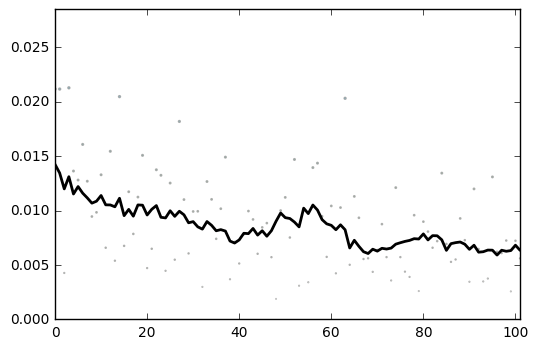

In [16]:
# Traçando linha média a cada 10% das amostras
err_data = [np.mean(err_list[i:i+((total_steps)/int(total_steps/10))]) for i in xrange(len(err_list)/((total_steps)/(total_steps/10))) ]
fig = plt.figure()
plt.axis([0,101,0.,max(err_data)*2])
plt.plot(err_data, 'black', lw=2)
plt.scatter(xrange(len(err_list)),err_list, s=np.multiply(100,err_list), c=err_list, cmap=plt.cm.GnBu, alpha=0.3)
plt.show()

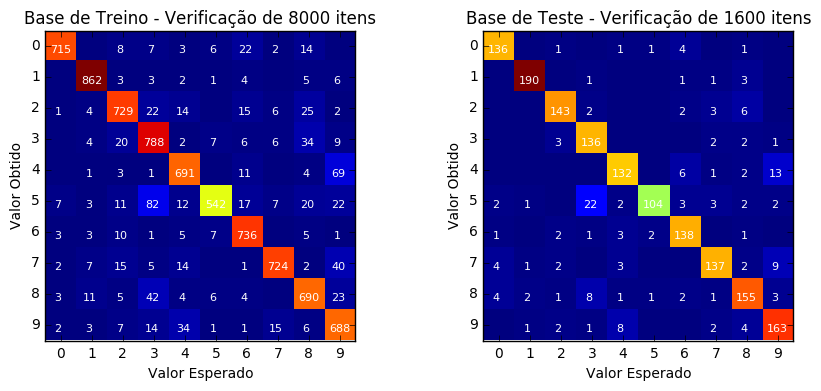

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

ax1.set_title(u'Base de Treino - Verificação de %d itens' % len(elem_set))
ax1.set_xlabel('Valor Esperado')
ax1.set_ylabel('Valor Obtido')
ax1.grid(False)
ax1.set_xticks(range(10))
ax1.set_yticks(range(10))
ax1.imshow(err_map_train, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(err_map_train):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            ax1.text(j-xoff, i+.2, int(count), fontsize=8, color='white')

ax2.set_title(u'Base de Teste - Verificação de %d itens' % (_test_set_len))
ax2.set_xlabel('Valor Esperado')
ax2.set_ylabel('Valor Obtido')
ax2.grid(False)
ax2.set_xticks(range(10))
ax2.set_yticks(range(10))
ax2.imshow(err_map_test, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(err_map_test):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            ax2.text(j-xoff, i+.2, int(count), fontsize=8, color='white')

### Backpropagation para geração de imagem

Utilização dos mesmos paramêtros calculados para o reconhecimento do dígito para produção do mapa $ \begin{bmatrix} 28 & 28 \end{bmatrix} $ de uma imagem

In [18]:
def predict_image(y,w2,b2,w1,b1):
    return tf.matmul(tf.matmul(Y - b2 ,tf.transpose(w2)),tf.transpose(w1))

In [19]:
def array_to_grayscale(image):
    l = [ image[0][k] for k in np.where(image[0]<0.)[0] ]
    l.sort()
    m1 = l[0]
    m2 = image[0, np.argmax(image)]

    for i in range(len(image)):
        image[i] += np.abs(m1)

    m2 = image[0, np.argmax(image)]    
    for i in range(len(image)):
        image[i] = (255.*image[i])/m2

    m1 = image[0,np.argmin(image)]
    m2 = image[0, np.argmax(image)]
    return image

def high_pass_filter(image,min_value):
    for i in np.where(image[0]<min_value):
        image[0][i] = 0
    for i in np.where(image[0]>=min_value):
        image[0][i] = 255 * (image[0][i]/255.)
    return image

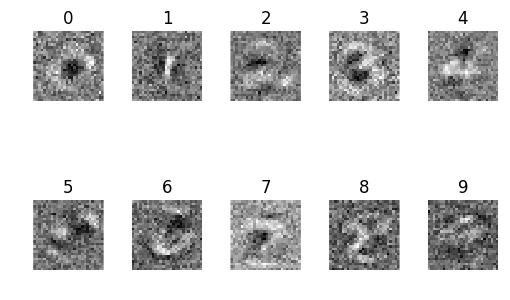

In [20]:
predict_image_op = predict_image(Y,w2,b2,w1,b1)


fig, axs = plt.subplots(2, 5)
plt.subplots_adjust(wspace=.4)

with tf.Session() as sess:
    saver.restore(sess, save_file_str)
    images = []
    b = 0
    for i in xrange(10):
        a = i%5
        if(i>4):
            b = 1
        ax = axs[b][a]
        arr = [0.] * 10
        arr[i] = 1.
        _fd = {Y:[arr]}
        B = array_to_grayscale(sess.run(predict_image_op, feed_dict=_fd))
        #B = high_pass_filter(array_to_grayscale(sess.run(predict_image_op, feed_dict=_fd)),138)
        ax.axis('off')
        ax.set_title(str(i))
        ax.imshow(B.reshape((28,28)),cmap=plt.cm.gray, interpolation='none')